In [1]:
## Imports: 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import StatisticalMetrics as SM 
import readRthRaw as RTH 
import snrCalc as SNRC
import glob
import re
import os 
from shutil import copyfile
import math
import seaborn as sns
sns.set_context('talk')

# trackTest-18Apr2019

### Experiment Notes: 
data stored at ircci-share/Data/track

	•	Analysis done by Jay

### Missing information:  
    - 

In [2]:
## Path/Constant variables:
experiment_path = "/Users/jaysoni/Desktop/trackTest-18Apr2019/"
## this is a local directory, (used to reduce processing time) a global directory can be used as well: 
## experiment_path = "/volumes/ircci-share/data/trackTest-18Apr2019/"

catheters = ["cath284", "cath299", "cath285"]
positions = ["iso", "offIso"]
sequences = ["fastHadamard", "SRI"]
coil_label_patternSRI = ["cathcoil4", "cathcoil5"]
coil_label_patternFH = ["cathHVC4", "cathHVC5"]
projection_label_pattern = ["P0", "P1", "P2", "P3"]
dither_label_pattern = ["D0", "D1", "D2"]
fieldofview = ["fov60"] 

linearRecomb = [[-1,1,1,-1],[-1,1,-1,1],[-1,-1,1,1]]
linearRecomb = np.array(linearRecomb)
linearRecomb = (3**0.5/4.0)*linearRecomb

## Ground truth Coordinates: 
Off_Iso_Transform = [8.025, 0.0, -149.71]

coordinates_iso = [[[3.738, 5.541, 1.565], [3.70, 5.564, -6.205]],  ## Cath284  (mm)
                   [[6.638, 5.914, 2.940], [6.774, 6.028, -4.828]],  ## Cath299 (mm)
                   [[5.969, 6.055, 0.381], [5.929, 6.079, -7.389]]]  ## Cath285 (mm)
                        ## Distal (4)          Proximal (5)
    
coordinates_offiso = [[[11.763, 5.541, -148.145], [11.725, 5.564, -155.915]],  ## Cath284  (mm)
                      [[14.663, 5.914, -146.77], [14.799, 6.028, -154.538]],  ## Cath299 (mm)
                      [[13.994, 6.055, -149.329], [13.954, 6.079, -157.099]]]  ## Cath285 (mm)
                          ## Distal (4)             Proximal (5)
    
    
Ground_Truth = [coordinates_iso, coordinates_offiso]



In [8]:
for seq in sequences:
    for cath in catheters: 
        for pos in positions: 
            if (seq == "SRI"): 
                path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                print(path)

                files = glob.glob(path+"cathcoil[4-5]*projections")
                for file in files: 
                    xsize,ysize,zsize,FOV,projNum,triggerTimes,respPhases,timestamps,projComplex = RTH.readProjections(file)
                    fts = RTH.reconstructProjections(projComplex,xsize,ysize)

                    file_suffix = (file.split("/"))[-1]
                    new_name = "warpedcoordsCentAlg1-" + seq + "-" + cath + "-" + pos + "-" + (file_suffix.split("."))[0]

                    ## CentAlg1 : is the standard centroid algorithm with 
                    ##      window_scale 2.5 and cut off value at 0.5 

                    ## CentAlg2 : is the standard centroid algorithm with 
                    ##      window_scale 2.5 and cut off value at 0 

                    ## CentAlg3 : is the new centroid algorithm with 
                    ##      peak normed gaussian and width is 8 mm

                    ## CentAlg4 : is the new centroid algorithm with 
                    ##      peak normed gaussian and width is 1 mm

                    txt_file = open(experiment_path + "WarpedCoordinates/" + new_name + ".txt", 'w')

                    lst_of_vals = [[],[],[]]

                    for index, element in enumerate(fts):
                        centroidInd, centroidCoord = SM.custm_centroid(element, FOV, 2.0, Cutoff_value=0.5)     
                                                   ##SM.new_centroid_algorithm(element, FOV, window_width=1)   
                                                                        ## calculates coil position
                                                                        ## using centroid algorithm

                        lst_of_vals[index%3].append(centroidCoord)                               


                    for i in range(min(len(lst_of_vals[0]),len(lst_of_vals[1]),len(lst_of_vals[2]))):
                        txt_file.write("{} {} {} \n".format(lst_of_vals[0][i],lst_of_vals[1][i],lst_of_vals[2][i]))  
                                                                              ## writes data to text file, 
                                                                              ## first column = x-axis 
                                                                              ## second column = y-axis
                                                                              ## third column = z-axis                                                             
                    txt_file.close()

            else:
                path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
                print(path)

                for coil_label in (coil_label_patternFH):
                    p0 = []
                    p1 = []
                    p2 = []
                    p3 = []
                    Projections = [p0,p1,p2,p3]
                    txt_file = open(experiment_path + "WarpedCoordinates/" + "warpedcoordsCentAlg1-" + seq + "-" + cath + "-" + pos + "-" + coil_label + ".txt", 'w')

                    ## CentAlg1 : is the standard centroid algorithm with 
                    ##      window_scale 2.5 and cut off value at 0.5 

                    ## CentAlg2 : is the standard centroid algorithm with 
                    ##      window_scale 2.5 and cut off value at 0 

                    ## CentAlg3 : is the new centroid algorithm with 
                    ##      peak normed gaussian and width is 8 mm

                    ## CentAlg4 : is the new centroid algorithm with 
                    ##      peak normed gaussian and width is 1 mm

                    for projection_number, projection_label in enumerate(projection_label_pattern): 
                        fft = [[],[],[]]
                        pNum = [0,0,0]
                        FOVS = [0,0,0]

                        for dither_number, dither_label in enumerate(dither_label_pattern): 
                            file_name = (glob.glob(path + coil_label + projection_label + dither_label + "*.projections"))[0]

                            xsize,ysize,zsize,FOV,projNum,triggerTimes,respPhases,timestamps,projComplex = RTH.readProjections(file_name)
                            fts = RTH.reconstructProjections(projComplex,xsize,ysize)

                            fft[dither_number] = fts 
                            pNum[dither_number] = projNum
                            FOVS[dither_number] = FOV

                        for index in range(min(pNum)):
                            mag0 = abs(fft[0][index])
                            mag1 = abs(fft[1][index])
                            mag2 = abs(fft[2][index])

                            peak0 = max(mag0) 
                            peak1 = max(mag1)
                            peak2 = max(mag2)

                            dither = np.argmax(np.array([peak0,peak1,peak2]))

                            centroidInd, centroidCoord = SM.custm_centroid(fft[dither][index], FOVS[dither], 2.0, Cutoff_value=0.5)
                                                       ##SM.new_centroid_algorithm(fft[dither][index], FOVS[dither], window_width=1)   
                                                                            ## calculates coil position
                                                                            ## using centroid algorithm

                            Projections[projection_number].append(centroidCoord)


                    for i in range(min(len(p0), len(p1), len(p2), len(p3))):
                        projection_array = np.array([[p0[i]], [p1[i]], [p2[i]], [p3[i]]])
                        coords = np.dot(linearRecomb, projection_array)

                        txt_file.write("{} {} {} \n".format(float(coords[0]),float(coords[1]),float(coords[2])))  


                    txt_file.close()

print("Done Copying!")

/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath284/fastHadamard_Tracking-iso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath284/fastHadamard_Tracking-offIso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath299/fastHadamard_Tracking-iso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath299/fastHadamard_Tracking-offIso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath285/fastHadamard_Tracking-iso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/fastHadamard/cath285/fastHadamard_Tracking-offIso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/SRI/cath284/SRI_Catheter_Tracking-iso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/SRI/cath284/SRI_Catheter_Tracking-offIso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/SRI/cath299/SRI_Catheter_Tracking-iso/
/Users/jaysoni/Desktop/trackTest-18Apr2019/SRI/cath299/SRI_Catheter_Tracking-offIso/
Had to break loop!
/Users/jaysoni/Desktop/trackTest-18Apr2019/SRI/cath285/SRI_Catheter_Tracking-iso/
/Users/jay

#### Unwarp the warped coordinates with the Gradient unwarping algorithm (semi-manual)

The coil coordinates which have been saved to the WarpedCoordinates folder could have potentially fallen victim to gradient warping and must be unwarped. 
    
To do this first open terminal: 
        - enter the command "ssh rtuser@raptor" 
        - when prompted for the password enter: "rufous"
        - copy the warped data into rtuser: "scp -r YourUserName@IPAddress:/path/to/WarpedCoordinates/ ~/path/to/save"
        - to run the unwarp function first change directories: "cd ~/Code/unwarpcoord/build/" 
        - then run the function: "./unwarpCoords ~/path/where/you/saved/WarpedCoordinates/ ../gw_coils.dat"
        - then copy the results back to your computer: "scp -r ~/path/where/you/saved/WarpedCoordinates/unwarped                                                                     YourUserName@IPAddress:/path/to/save/UnwarpedCoordinates" 
        - When prompted for password enter the password to login to your user on that computer

For additional help, speak with Bonny!

In [12]:
## This bit of code copys the unwarped coordinates for each coil and places them in the correct folder so they can be easily
## accessed for future use. 
counter = 0

for seq in sequences:
    for cath in catheters: 
        for pos in positions: 
            if (seq == "SRI"): 
                path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                path_unwarped = experiment_path + "UnwarpedCoordinates/"

                files = glob.glob(path_unwarped + "warpedcoordsCentAlg1-" + seq + "-" + cath + "-" + pos + "-cathcoil*-unwarped.txt")
                                     
                for file in files: 
                    name = (file.split("/"))[-1]
                    copyfile(file, path + name)     
                    counter += 1
            
            else:
                path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
                path_unwarped = experiment_path + "UnwarpedCoordinates/"

                file1_name = "warpedcoordsCentAlg1-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC4-unwarped.txt"
                file2_name = "warpedcoordsCentAlg1-" + seq + "-" + cath + "-" + pos + "-" + "cathHVC5-unwarped.txt"
                

                copyfile(path_unwarped + file1_name, path + file1_name)
                copyfile(path_unwarped + file2_name, path + file2_name)
                counter += 2

print("Done Copying!")
print(counter)

Done Copying!
24


fastHadamard cath284 isoError 1.8363596845763286, Std 1.9027422200220967, n = 111 

fastHadamard cath284 offIsoError 8.008224199572453, Std 1.6680198224137772, n = 110 

fastHadamard cath299 isoError 1.9580123908822626, Std 1.749506379588015, n = 106 

fastHadamard cath299 offIsoError 13.415924154003013, Std 1.6748905720740583, n = 108 

fastHadamard cath285 isoError 1.8809853514862986, Std 1.7284030876760634, n = 108 

fastHadamard cath285 offIsoError 9.223626173417014, Std 2.278321149542258, n = 109 

SRI cath284 isoError 1.0002232923167456, Std 1.1763168534310207, n = 335 

SRI cath284 offIsoError 9.259087219090276, Std 0.8182367291232926, n = 336 

SRI cath299 isoError 2.6685146485399027, Std 1.472857839207704, n = 334 

SRI cath299 offIsoError 13.565994953762672, Std 1.9307150596089602, n = 335 

SRI cath285 isoError 1.6982171876808314, Std 1.7070888289315682, n = 348 

SRI cath285 offIsoError 9.568901679900396, Std 2.648874541022194, n = 336 

[1.0002232923167456, 2.6685146485399

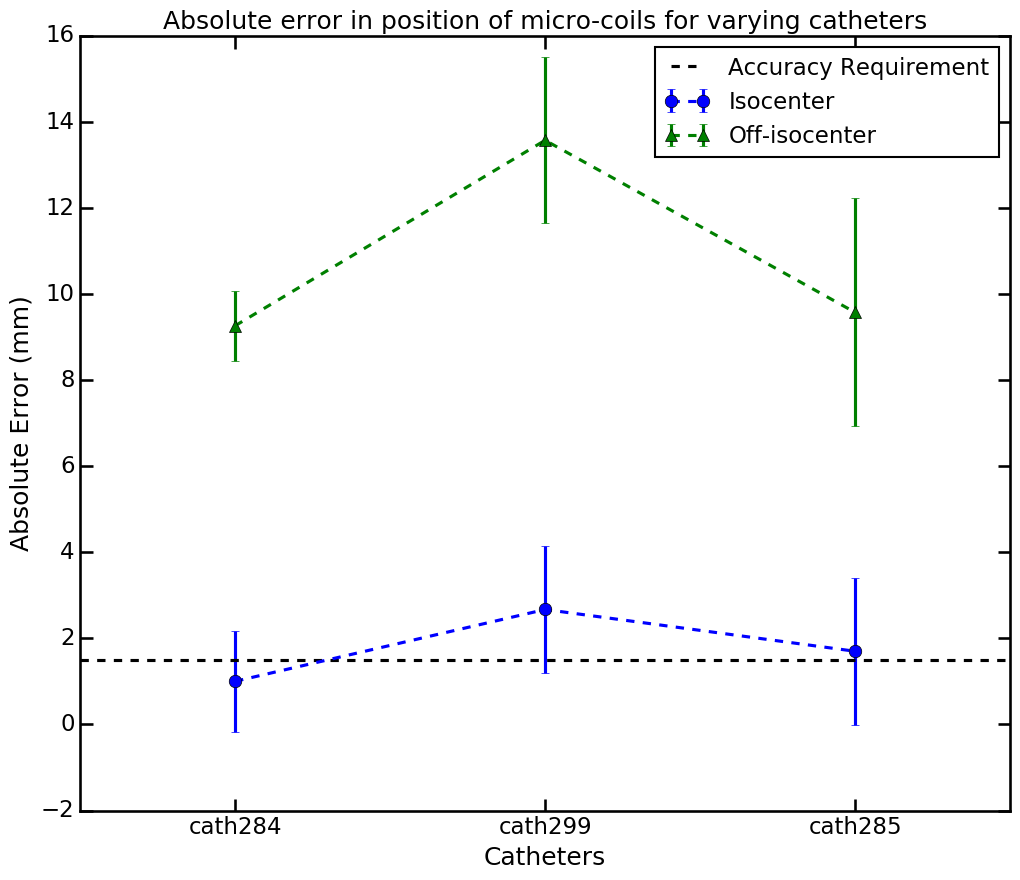

Done!
8.033117854296153
0.999999999915
p_val = 1.7003976005014465e-10
1.7003976005e-10


In [8]:
SRI_iso_error = [[], ## cath284
                 [], ## cath299
                 []] ## cath285

SRI_off_error = [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_iso_error =  [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_off_error =  [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Data_Array = [[Fh_iso_error, Fh_off_error], #FH 
              [SRI_iso_error, SRI_off_error]] #SRI  

SRI_iso =       [[], ## cath284
                 [], ## cath299
                 []] ## cath285

SRI_off =       [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_iso =        [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Fh_off =        [[], ## cath284
                 [], ## cath299
                 []] ## cath285

Data_Array2 = [[Fh_iso, Fh_off],  #FH 
               [SRI_iso, SRI_off]]   # SRI

for SIndex, seq in enumerate(sequences): 
    for CIndex, cath in enumerate(catheters): 
        for PIndex, pos in enumerate(positions): 
            
            if (seq == "fastHadamard"):
                path = experiment_path + seq + "/" + cath + "/" + 'fastHadamard_Tracking-' + pos + "/"
            elif (seq == 'SRI'): 
                path = experiment_path + seq + "/" + cath + "/" + 'SRI_Catheter_Tracking-' + pos + "/"
                
            files = glob.glob(path + "warpedcoordsCentAlg4*unwarped.txt")
            
            X_coord = []
            Y_coord = []
            Z_coord = []
            
            for file in files: 

                
                file_suffix1 = (((file.split("/"))[-1]).split("-"))[-3] ## cathcoil#      two different file name types 
                file_suffix2 = (((file.split("/"))[-1]).split("-"))[-2] ## cathHVC#      need to  be seperated to determine coil number! 
            
                if((file_suffix2 == "cathHVC4") or (file_suffix1 == "cathcoil4")): 
                    true_position = Ground_Truth[PIndex][CIndex][0] 

                elif((file_suffix2 == "cathHVC5") or (file_suffix1 == "cathcoil5")): 
                    true_position = Ground_Truth[PIndex][CIndex][1]
                
                else: 
                    raise Exception('Error could not find suffix! : {}'.format(file))
                
                X_truth = true_position[0]
                Y_truth = true_position[1]
                Z_truth = true_position[2]
                
                file_coords = open(file, 'r')
                experiment_info = file_coords.readlines()
                file_coords.close()
                
                for line in experiment_info:
                    experimental_coords = (line.split(" ")) 
                    X_coord.append(float(experimental_coords[0]) - X_truth)
                    Y_coord.append(float(experimental_coords[1]) - Y_truth)
                    Z_coord.append(float(experimental_coords[2]) - Z_truth)
            
            X_coord_mean = np.mean(X_coord)
            Y_coord_mean = np.mean(Y_coord)
            Z_coord_mean = np.mean(Z_coord)

            X_std = np.std(X_coord)
            Y_std = np.std(Y_coord)
            Z_std = np.std(Z_coord)

            Std = ((X_std)**2 + (Y_std)**2 + (Z_std)**2)**(1/2)

            Error = ((X_coord_mean)**2 + (Y_coord_mean)**2 + (Z_coord_mean)**2)**(1/2)

            Data_Array[SIndex][PIndex][CIndex].append(Error)
            Data_Array[SIndex][PIndex][CIndex].append(Std)
            Data_Array2[SIndex][PIndex][CIndex].append(X_coord)
            Data_Array2[SIndex][PIndex][CIndex].append(Y_coord)
            Data_Array2[SIndex][PIndex][CIndex].append(Z_coord)

            print(seq + ' ' + cath + ' ' + pos + 'Error {}, Std {}, n = {} \n'.format(Error, Std, len(experiment_info)))

            
Iso_error = [SRI_iso_error[0][0], SRI_iso_error[1][0], SRI_iso_error[2][0]] 
Iso_std = [SRI_iso_error[0][1], SRI_iso_error[1][1], SRI_iso_error[2][1]]

Off_error = [SRI_off_error[0][0], SRI_off_error[1][0], SRI_off_error[2][0]]
Off_std = [SRI_off_error[0][1], SRI_off_error[1][1], SRI_off_error[2][1]]

print(Iso_error)
hori_axis = np.array([0.5, 1.5, 2.5])

plt.figure(figsize=(12,10))
plt.title("Absolute error in position of micro-coils for varying catheters")
plt.ylabel("Absolute Error (mm)")
plt.xlabel("Catheters")
plt.errorbar(hori_axis, Iso_error, yerr = Iso_std, fmt = "--o", label = 'Isocenter')
plt.errorbar(hori_axis, Off_error, yerr = Off_std, fmt = "--^", label = 'Off-isocenter')
plt.hlines(1.5, 0, 3, linestyles='dashed', label='Accuracy Requirement')
plt.legend()
plt.xticks(hori_axis, catheters)
plt.show()
        
print('Done!')

1.79
2.30333333333


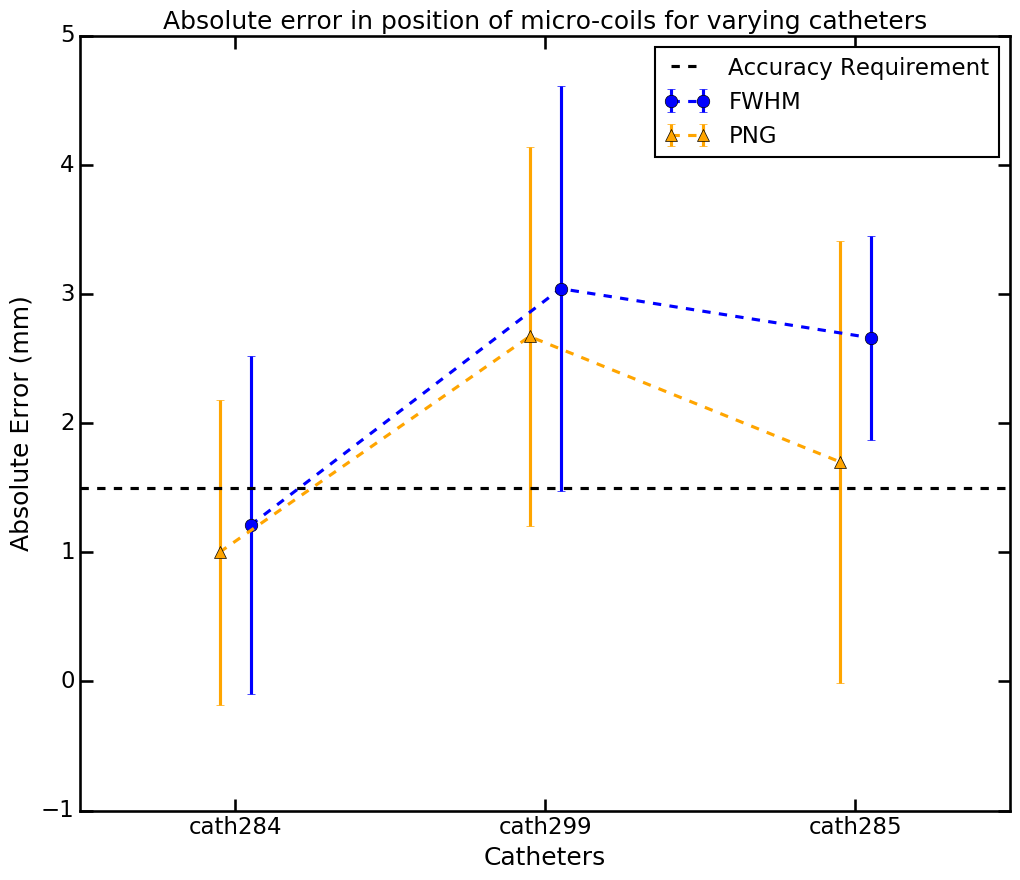

In [3]:
## temp copy paste to graph multiple algorithms on same chart 

SRI_iso_PNG_error = [1.00, 2.67, 1.70]           ## Cath284, Cath299, Cath285
SRI_iso_PNG_std = [1.18, 1.47, 1.71] 

SRI_iso_FWHM_error = [1.21, 3.04, 2.66]          ## Cath284, Cath299, Cath285
SRI_iso_FWHM_std = [1.31, 1.57, 0.79] 

# print(np.mean(SRI_iso_PNG_error))
# print(np.mean(SRI_iso_FWHM_error))

hori_axis = np.array([1,2,3])

plt.figure(figsize=(12,10))
plt.title("Absolute error in position of micro-coils for varying catheters")
plt.ylabel("Absolute Error (mm)")
plt.xlabel("Catheters")
plt.errorbar(hori_axis + 0.55, SRI_iso_FWHM_error, yerr = SRI_iso_FWHM_std, color = 'blue', fmt = "--o", label = 'FWHM')
plt.errorbar(hori_axis + 0.45, SRI_iso_PNG_error, yerr = SRI_iso_PNG_std, color = 'orange', fmt = "--^", label = 'PNG')
plt.hlines(1.5, 1, 4, linestyles='dashed', label='Accuracy Requirement')
plt.legend()
plt.xticks(hori_axis + 0.5, catheters)
plt.show()